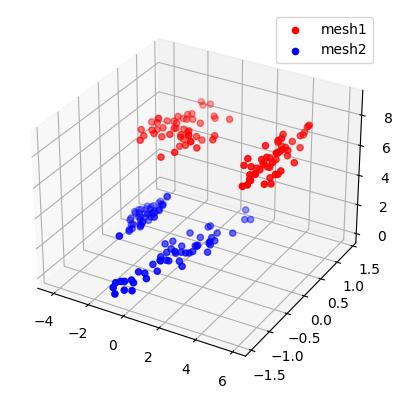

10000


In [1]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import networkx as nx
import random


#####################

threshold = 3
gamma = 10
eps = 1e-2
eta = 1
verbose = False
nitermax = 20
#####################

random_state=1
np.random.seed(random_state)
#random.seed(random_state)

def generate_data(nsample, ratio):
    # Generate first ellipse
    s = np.random.uniform(size=(nsample, 3))
    x1 = np.zeros_like(s)
    x1[:, 0] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.cos(2 * np.pi * s[:, 2])
    )
    x1[:, 1] = 2 * np.sqrt(s[:, 0]) * np.sin(2 * np.pi * s[:, 1])
    x1[:, 2] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.sin(2 * np.pi * s[:, 2])
    )
    rot = 0.5 * np.sqrt(2) * np.array([[1, -1, 0], [1, 1, 0], [0, 0, 1]])
    x1 = x1.dot(rot)

    # Generate second circle
    s = np.random.uniform(size=(nsample, 3))
    x2 = np.zeros_like(s)
    x2[:, 0] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.cos(2 * np.pi * s[:, 2])
    )
    x2[:, 1] = np.sqrt(s[:, 0]) * np.sin(2 * np.pi * s[:, 1])
    x2[:, 2] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.sin(2 * np.pi * s[:, 2])
    )
    x2 = x2 + np.array([5.0, 0.0, 0.0])
    x = np.concatenate((x1, x2)) + np.array([0.0, 0.0, 8.0])

    # Generate second data drom translation
    y = np.concatenate((x1[:, :2], s[:, :2] + np.array([-4.0, 0.0])))
    angle = -np.pi / 4
    x[:nsample] = x[:nsample].dot(
        np.array(
            [
                [np.cos(angle), np.sin(angle), 0],
                [-np.sin(angle), np.cos(angle), 0],
                [0, 0, 1],
            ]
        )
    )
    y[nsample:] = (y[nsample:] - np.mean(y[nsample:], axis=0)).dot(
        np.array(
            [[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]
        )
    ) + np.mean(y[nsample:], axis=0)

    # Generate weights
    a, b = np.ones(x.shape[0]) / x.shape[0], np.ones(y.shape[0]) / y.shape[0]
    b[:n1], b[n1:] = (1 - ratio) * b[:n1], ratio * b[n1:]
    b = b / np.sum(b)
    return a, x, b, y

n1 = 50
ratio = 0.7
a, x, b, y = generate_data(n1, ratio)
x = np.array(x)
y = np.array(y)

D1 = sp.spatial.distance.cdist(x, x)
D2 = sp.spatial.distance.cdist(y, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:, 0], x[:, 1], x[:, 2], color='red', label='mesh1')
ax.scatter(y[:, 0], y[:, 1], color='blue', label='mesh2')

ax.legend()
plt.show()


# P = sgwconv.supervised_gromov_wasserstein_conv(C1, C2, nitermax=20, threshold=100)
######################################################################################
def perform_sOT_log(G, a, b, eps, options):

    niter = options['niter_sOT']
    f     = options['f_init']
    g     = options['g_init']
    M     = options['penalty']

    # Err = np.array([[1, 1]])

    for q in range(niter):   
        f = np.minimum(eps * np.log(a) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=1)+ 10**-20) + f, M)
        g = np.minimum(eps * np.log(b) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=0)+ 10**-20) + g, M)

    P = np.exp((f[:, None] + g[None, :] - G) / eps)
    
    return P, f, g

def vertex_with_most_edges(graph):
    degrees = dict(graph.degree())     
    max_degree = max(degrees.values())
    max_degree_vertices = [vertex for vertex, degree in degrees.items() if degree == max_degree]

    return max_degree_vertices, max_degree




n = D1.shape[0]
m = D2.shape[0]
C1 = D1.copy()
C2 = D2.copy()
  
#build graph and find an approximation of min vertex covering
G = nx.Graph()
for i in range(n):
    for j in range(m):
        vertex = (i+1, j+1) 
        G.add_node(vertex)

tensor4 = np.zeros((n, m, n, m))

C1_exp = C1[:, None, :, None]
C2_exp = C2[None, :, None, :]
tensor4 = (C1_exp - C2_exp)**2
    
positions = np.where(tensor4 > threshold**2) 
vertex_positions = positions[0] + 1, positions[1] + 1, positions[2] + 1,positions[3] + 1

for i in range(len(positions[0])) :
    first_elements = [arr[i-1] for arr in vertex_positions]
    vertex1 = (first_elements[0],first_elements[1])
    vertex2 = (first_elements[2],first_elements[3])
    G.add_edge(vertex1, vertex2) 
    
num_vertices_with_edges = sum(1 for v in G.nodes() if G.degree(v) > 0)

print(num_vertices_with_edges)    

In [2]:
tuples_set = set()
B = G.copy()

while B.edges:
    vertices, degree = vertex_with_most_edges(B)
    vertex = random.choice(vertices)
    B.remove_node(vertex)
    tuples_set.add(vertex)

if not B.edges and verbose:
    print("No more edges in the graph. ")  
if verbose:
    print(f"Minimum vertex cover algorithm is done, which finds {len(tuples_set)} out of {m * n} entries are 0 in the coupling P!")

KeyboardInterrupt: 

In [ ]:
#run sot and update P

a = np.array([1 / n] * n, dtype=float)
aa = a + 1e-1 * np.random.rand(n)
b = np.array([1 / m] * m, dtype=float)
bb = b + 1e-1 * np.random.rand(m)

aa = aa / np.linalg.norm((aa), ord=1)
bb = bb / np.linalg.norm((bb), ord=1)
    
#real convergence value
#eta = eps/(np.sqrt(2)* n * m * min(np.max(a), np.max(b)) * max(np.max(C1)**2,np.max(C2)**2) + eps)
    
    
P = np.outer(aa, bb) 
f = np.zeros(n)
g = np.zeros(m)
p_values = range(nitermax)
sgw_values = []


print(np.max(C1)**2)
print(np.max(C2)**2)
print(max(np.max(C1)**2,np.max(C2)**2))

for p in p_values:
        
    D = np.zeros((n, m)) 
    P_reshaped = P.reshape(1, 1, n, m) 
    D = np.sum(tensor4 * P_reshaped, axis=(-2, -1))
    sgw = np.sum(D * P)+gamma*(np.sum(a)+np.sum(b)-2*np.sum(P))+eps*np.sum(P * (np.log(P+10**(-20)*np.ones((n,m)))-np.ones((n,m))))
    sgw_values.append(sgw)
    
    D = 2*eta*D+eps*(eta-1)*np.log(P+10**(-20)*np.ones((n,m)))
                    
    for s, t in tuples_set:
        D[s-1, t-1] = np.inf
        
    options = {
    'niter_sOT': 10**5,
    'f_init': np.zeros(n),
    'g_init': np.zeros(m),
    'penalty': eta*gamma
    }
        
    P,f,g = perform_sOT_log(D, a, b, eps, options)

In [ ]:

def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1):

    fig = plt.figure()
    
    ax = plt.axes(projection='3d') 
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')

    ax.set_title(r'$\gamma=$' + str(gamma) + r' $\rho=$' + str(threshold))
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])
    
plot_mapping(P, y, x, thresh=0.00000001)
#plt.savefig('./1108_rho_gamma_1eta_epsilon.png') 
np.savetxt('test_mvc_time.csv', P, delimiter=',', fmt='%.10f')